In [1]:
import warnings

from compare_variance_residual.simulated.simulation import plot_variance_vs_residual

warnings.simplefilter(action='ignore')
import numpy as np

from variance_partitioning import variance_partitioning
from himalaya.progress_bar import bar
from residual import residual_method
from simulation import generate_dataset
import matplotlib.pyplot as plt

In [2]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

In [9]:
def run_experiment(variable_values, variable_name, n_runs, n_observations, unique_contributions, n_features_list,
                   n_targets, n_samples_train, n_samples_test, noise_level, random_distribution, ignore_negative_r2,
                   use_refinement, use_ols, x_is_log=False):
    predicted_variance = []
    predicted_residual = []

    for value in bar(variable_values, title=f"Varying {variable_name}"):
        variance_runs = []
        residual_runs = []

        if variable_name == "sample sizes training":
            n_samples_train = int(value)
        elif variable_name == "sample sizes testing":
            n_samples_test = int(value)
        elif variable_name == "feature size":
            n_features_list = [int(value), int(value)]
        elif variable_name == "number of targets":
            n_targets = int(value)
        elif variable_name == "relative amount of noise in the target":
            noise_level = value
        elif variable_name == "unique contributions":
            unique_contributions = value
        elif variable_name == "sampling distribution":
            random_distribution = value

        for run in range(n_runs):
            (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(
                n_features_list=n_features_list, n_targets=n_targets,
                n_samples_train=n_samples_train, n_samples_test=n_samples_test,
                noise=noise_level, unique_contributions=unique_contributions,
                random_distribution=random_distribution, random_state=run + 100)

            partitioning = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=use_refinement,
                                                 ignore_negative_r2=ignore_negative_r2)
            residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=use_ols,
                                       ignore_negative_r2=ignore_negative_r2)
            variance_runs.append(partitioning)
            residual_runs.append(residual)

        predicted_variance.append(variance_runs)
        predicted_residual.append(residual_runs)

    plot_variance_vs_residual(variable_values, variable_name, predicted_variance, predicted_residual,
                              unique_contributions, x_is_log=x_is_log, n_runs=n_runs, n_observations=n_observations,
                              n_features_list=n_features_list, n_targets=n_targets, n_samples_train=n_samples_train,
                              n_samples_test=n_samples_test, noise_level=noise_level,
                              random_distribution=random_distribution, ignore_negative_r2=ignore_negative_r2)

# Set default values to be used in the tests

In [4]:
n_observations = 10
n_runs = 10
unique_contributions = [0.6, 0.2]
n_features_list = [100, 100]
n_targets = 100
n_samples_train = 100
n_samples_test = 100
noise_level = 0.0
random_distribution = "normal"
ignore_negative_r2 = True

use_refinement = False
use_ols = False

# Varying distributions

In [5]:
random_distributions = ["normal", "uniform", "exponential", "gamma", "beta", "poisson", "lognormal", "pareto"]

[........................................] 100% | 18.53 sec | Varying sampling distribution | 


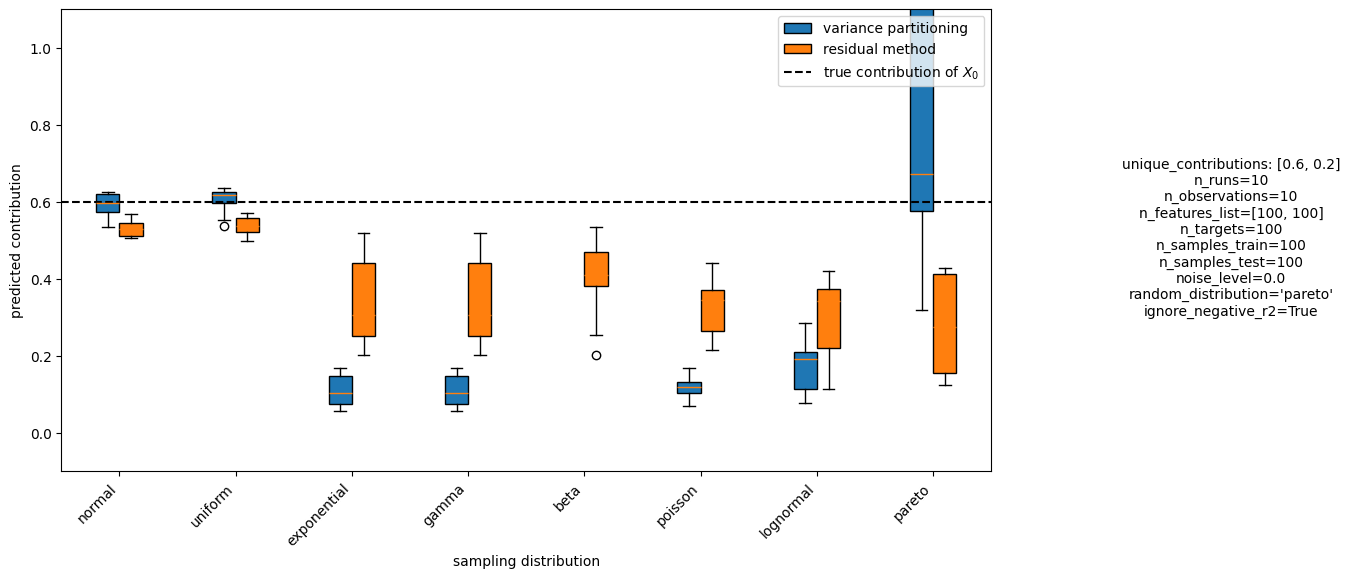

In [6]:
run_experiment(random_distributions, "sampling distribution", n_runs, n_observations, unique_contributions,
               n_features_list, n_targets, n_samples_train, n_samples_test, noise_level, random_distribution,
               ignore_negative_r2, use_refinement, use_ols)

# Test varying sample sizes

In [5]:
n_sample_sizes = n_observations
sample_sizes = np.logspace(1, 3, n_sample_sizes)

## varying train sample sizes

[........................................] 100% | 48.89 sec | Varying sample sizes training | 


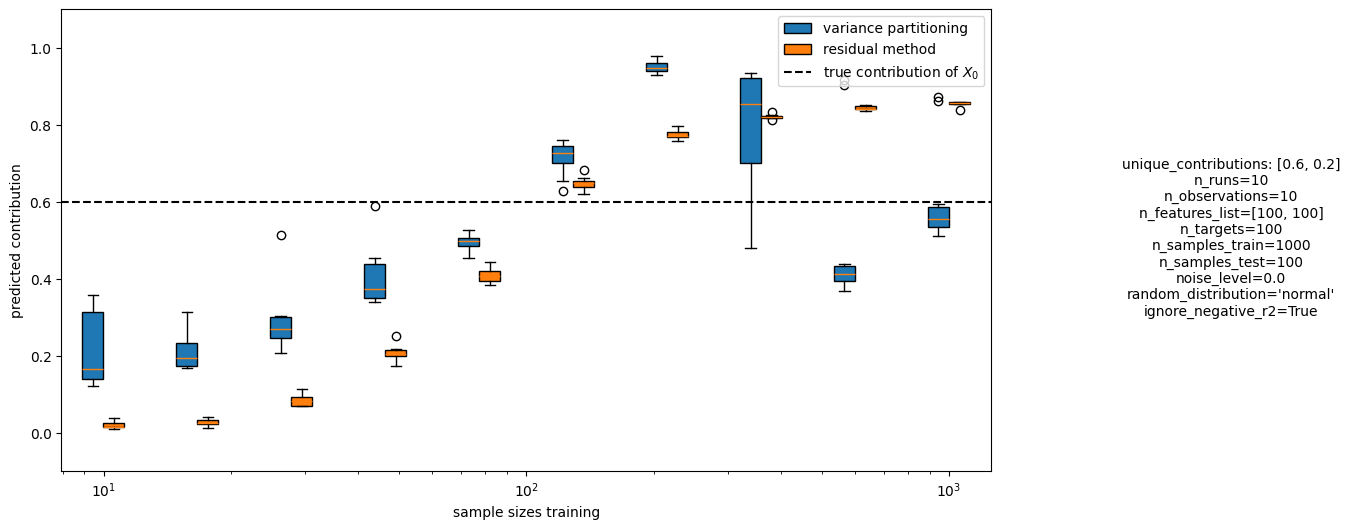

In [6]:
run_experiment(sample_sizes, "sample sizes training", n_runs, n_observations, unique_contributions, n_features_list,
               n_targets, n_samples_train, n_samples_test, noise_level, random_distribution, ignore_negative_r2,
               use_refinement, use_ols, x_is_log=True)

## varying test sample sizes

[........................................] 100% | 23.76 sec | Varying sample sizes testing | 


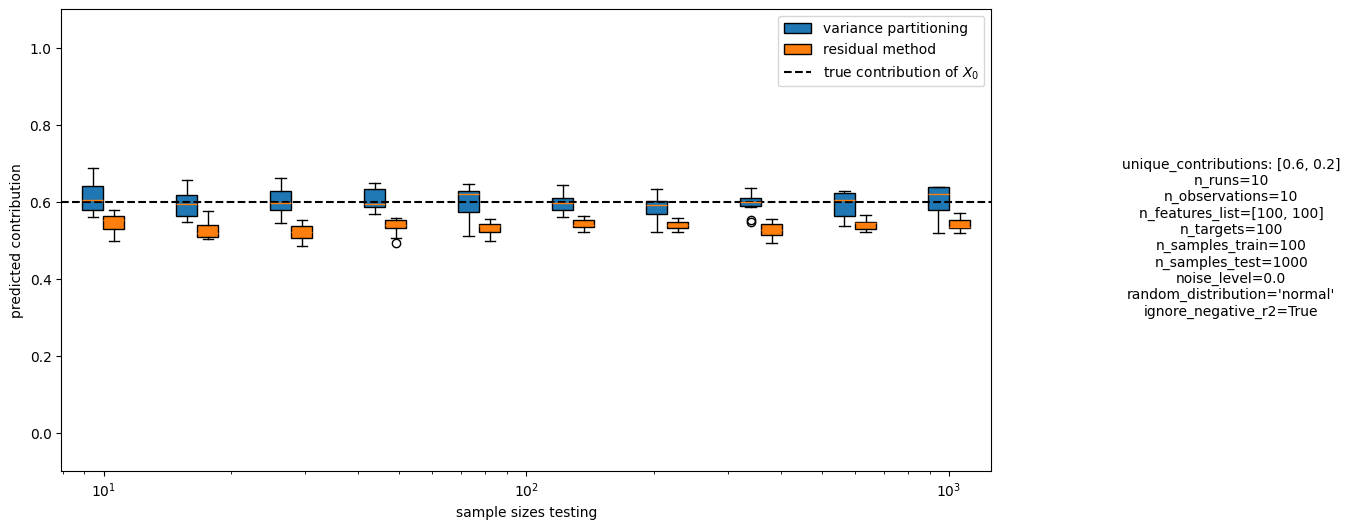

In [7]:
run_experiment(sample_sizes, "sample sizes testing", n_runs, n_observations, unique_contributions, n_features_list,
               n_targets, n_samples_train, n_samples_test, noise_level, random_distribution, ignore_negative_r2,
               use_refinement, use_ols, x_is_log=True)

# Test varying feature sizes

In [10]:
n_feature_sizes = n_observations
feature_sizes = np.logspace(0, 4, n_feature_sizes)

[........................................] 100% | 27.91 sec | Varying feature size | 


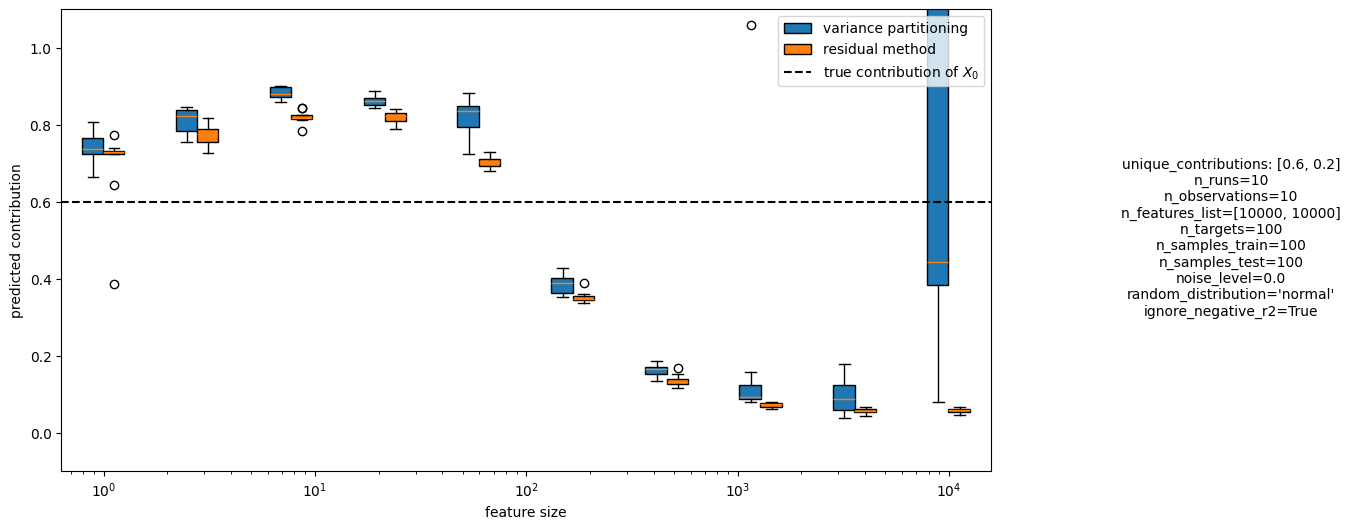

In [11]:
run_experiment(feature_sizes, "feature size", n_runs, n_observations, unique_contributions, n_features_list, n_targets,
               n_samples_train, n_samples_test, noise_level, random_distribution, ignore_negative_r2, use_refinement,
               use_ols, x_is_log=True)

# varying target size

In [7]:
n_target_sizes = n_observations
target_sizes = np.logspace(0, 4, n_target_sizes)

[........................................] 100% | 32.42 sec | Varying number of targets | 


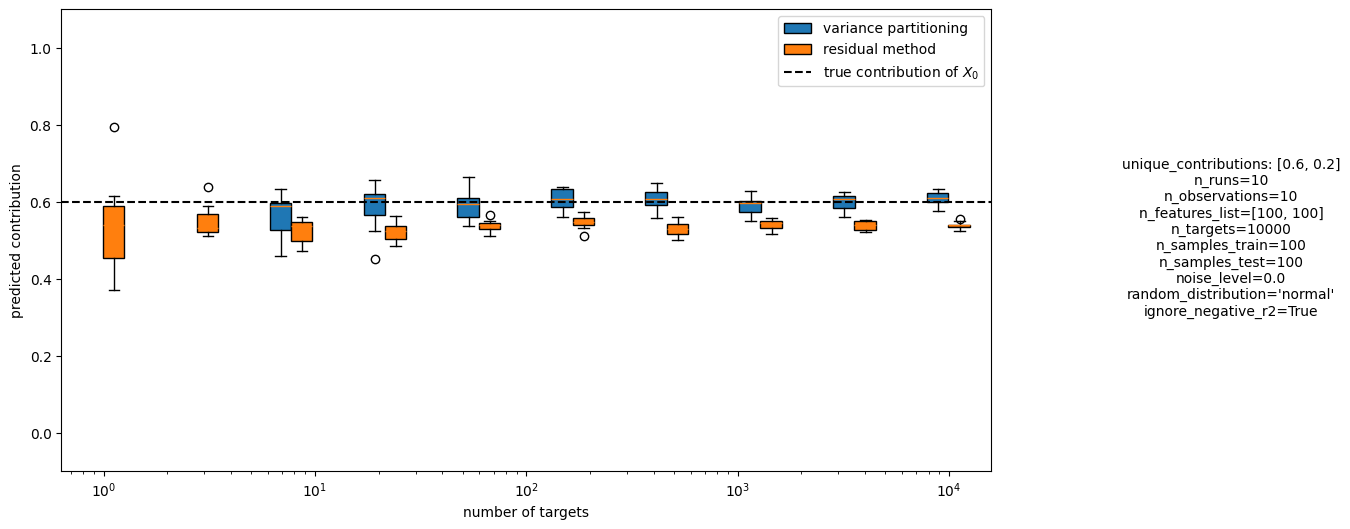

In [9]:
run_experiment(target_sizes, "number of targets", n_runs, n_observations, unique_contributions, n_features_list,
               n_targets, n_samples_train, n_samples_test, noise_level, random_distribution, ignore_negative_r2,
               use_refinement, use_ols, x_is_log=True)

# Test varying noise levels

In [20]:
n_noise_levels = n_observations
noise_levels = np.linspace(0, 1, n_noise_levels)

[........................................] 100% | 26.28 sec | Varying relative amount of noise in the target | 


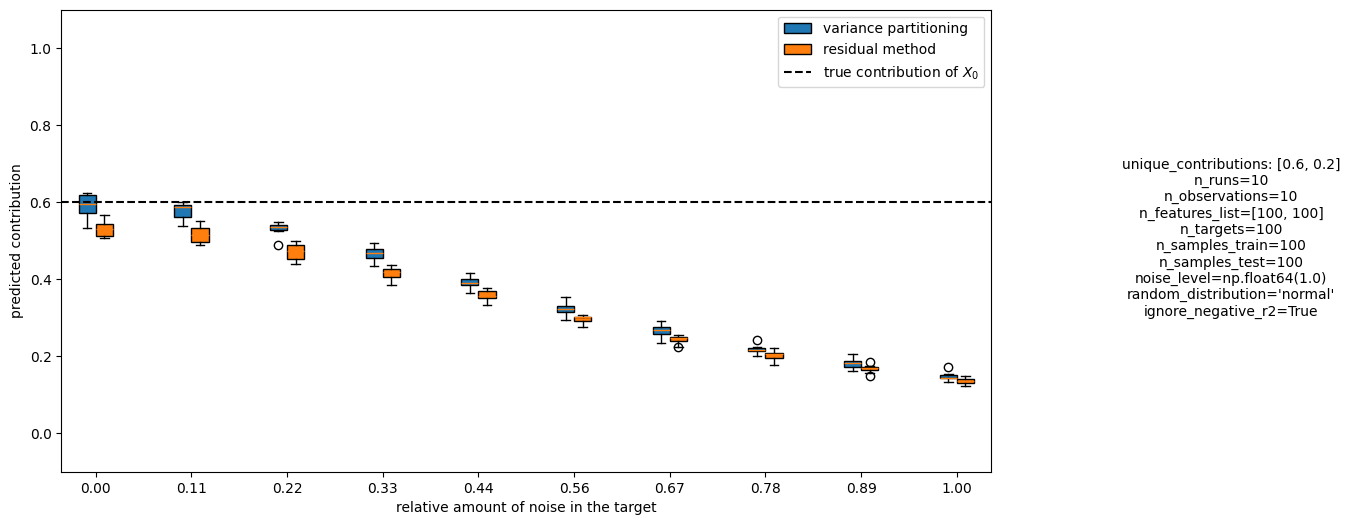

In [21]:
run_experiment(noise_levels, "relative amount of noise in the target", n_runs, n_observations, unique_contributions,
               n_features_list, n_targets, n_samples_train, n_samples_test, noise_level, random_distribution,
               ignore_negative_r2, use_refinement, use_ols)

# Test varying unique contributions of $X_0$ and $X_1$

In [17]:
n_contributions = n_observations
x0_unique_contributions = np.linspace(0, 1, n_contributions)
# convert from np to python
x0_unique_contributions = [round(float(x), 2) for x in x0_unique_contributions]

[........................................] 100% | 23.44 sec | Varying unique contributions | 


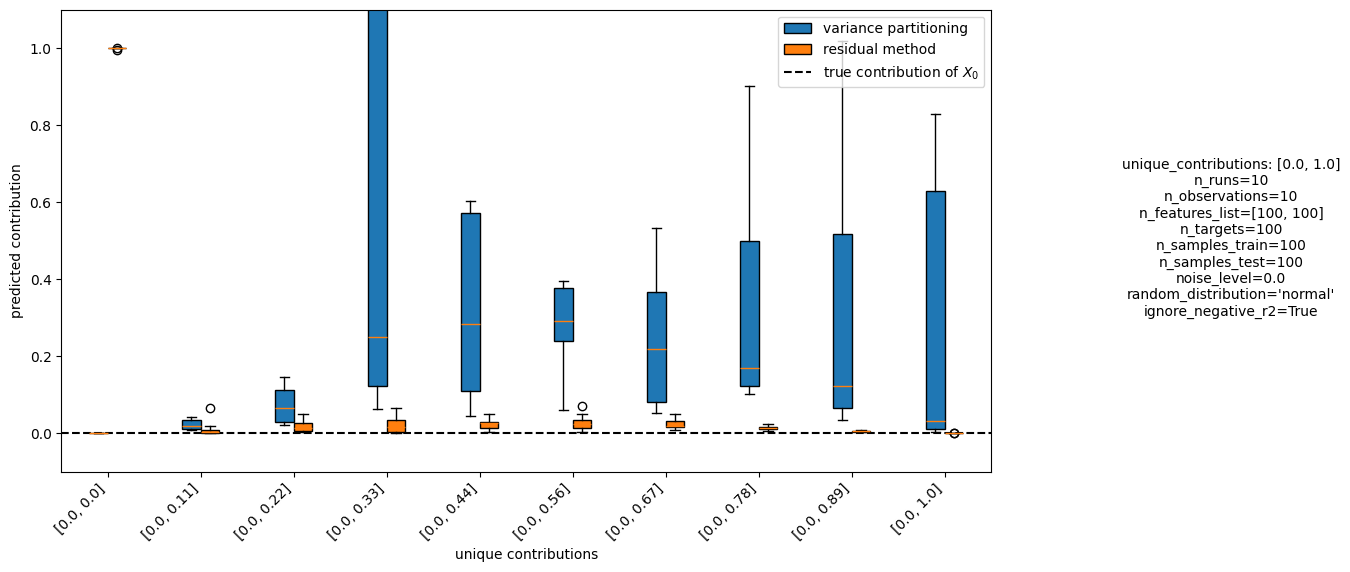

[........................................] 100% | 22.28 sec | Varying unique contributions | 


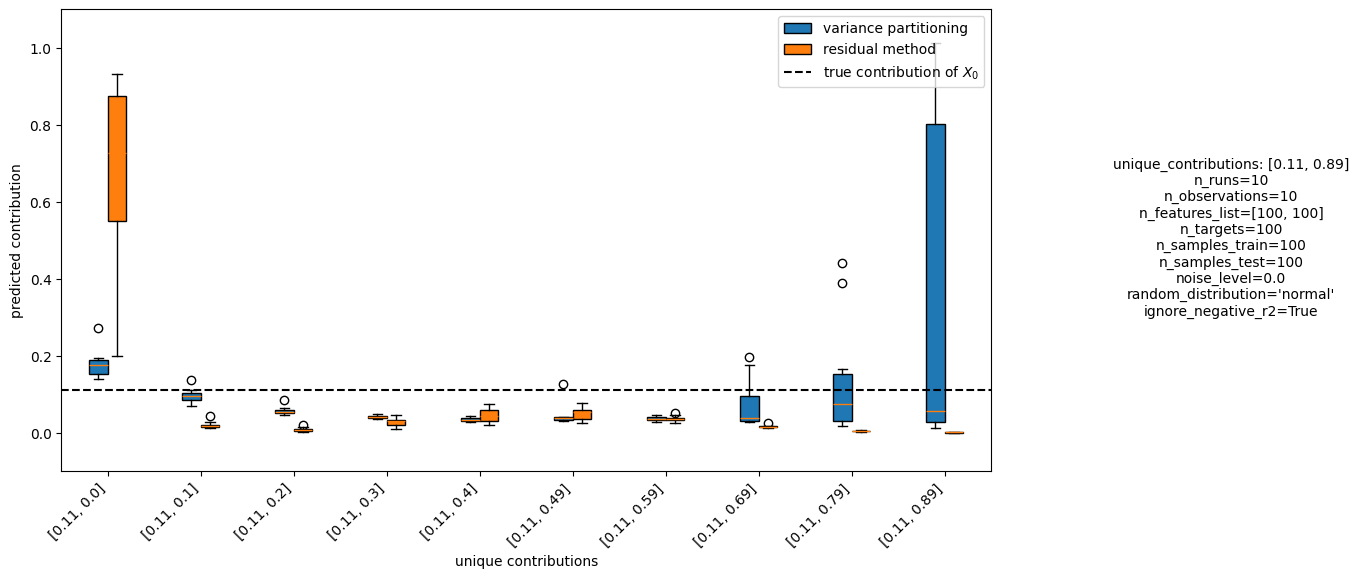

[........................................] 100% | 24.51 sec | Varying unique contributions | 


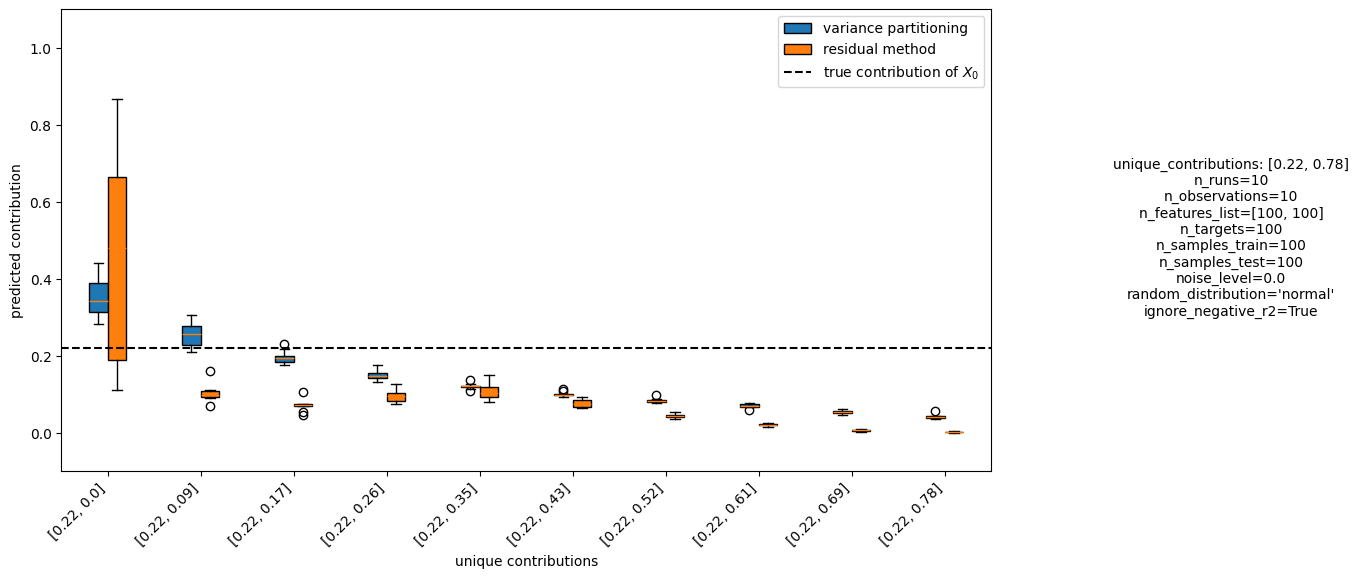

[........................................] 100% | 25.78 sec | Varying unique contributions | 


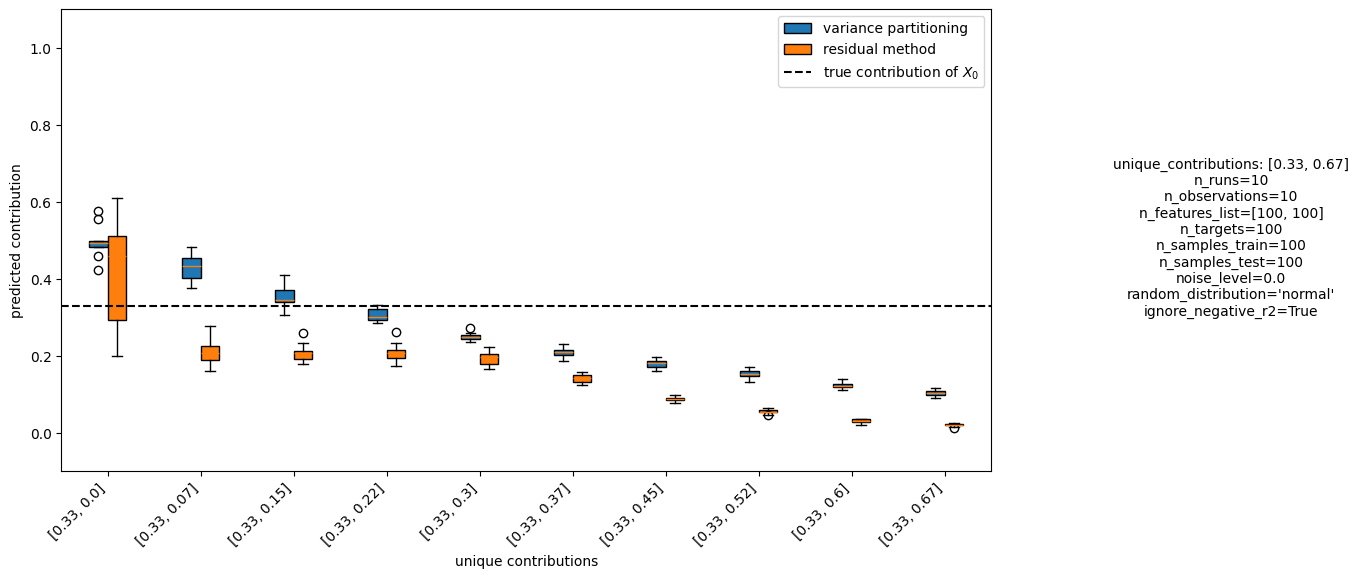

[........................................] 100% | 24.71 sec | Varying unique contributions | 


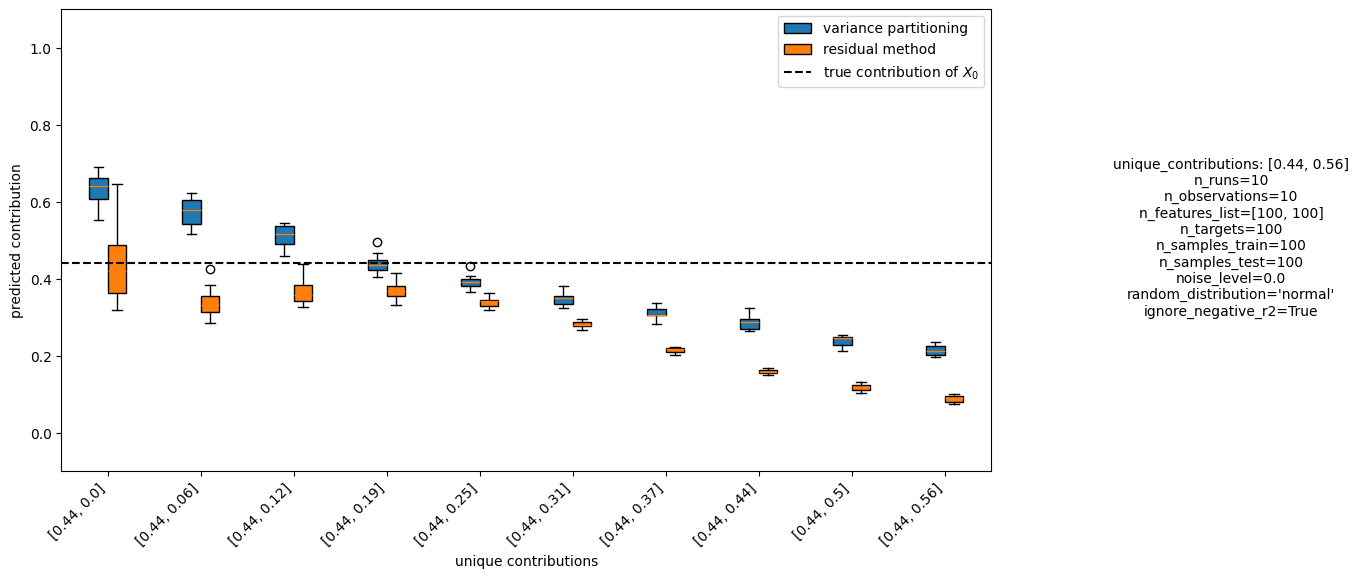

[........................................] 100% | 23.97 sec | Varying unique contributions | 


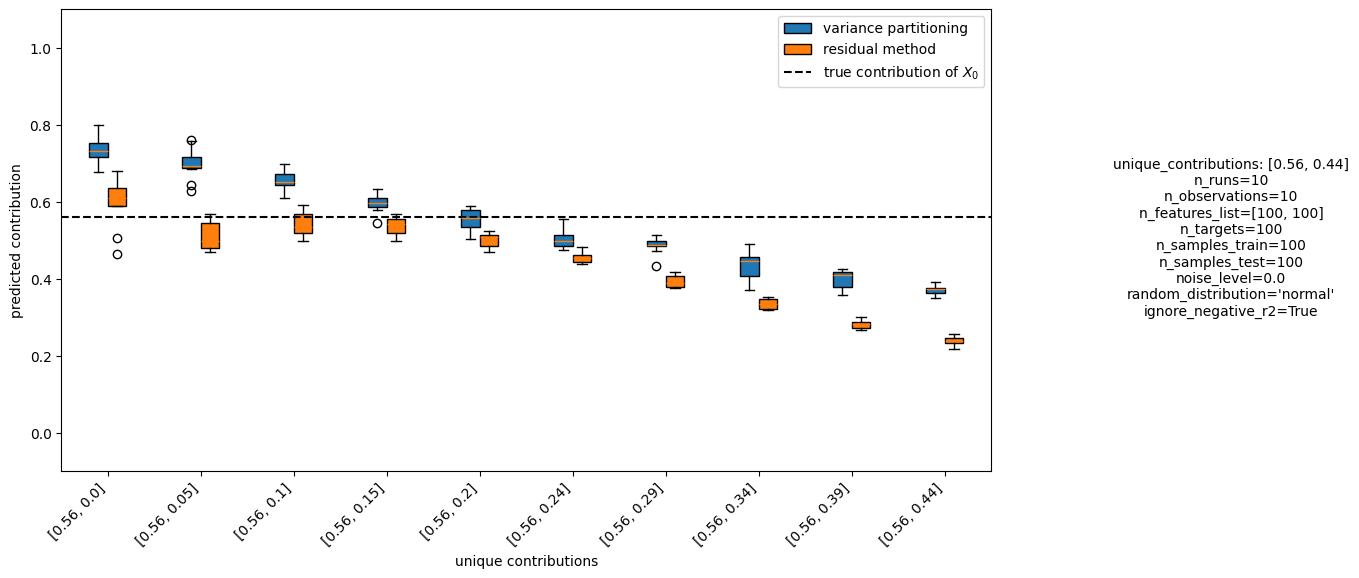

[........................................] 100% | 23.60 sec | Varying unique contributions | 


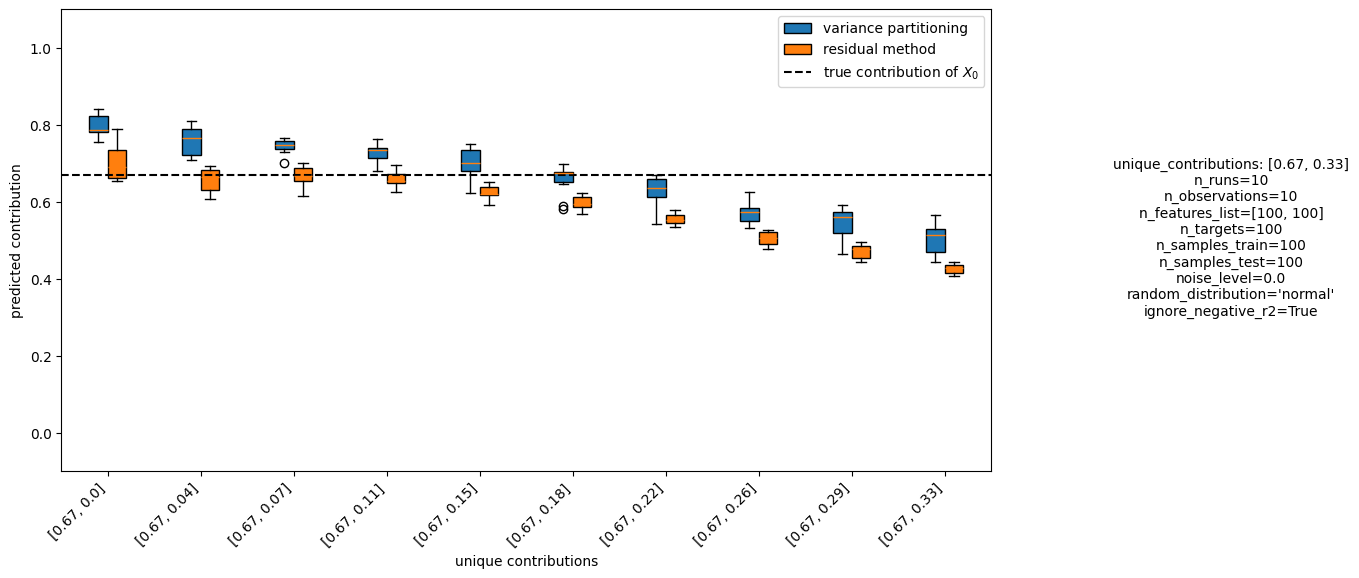

[........................................] 100% | 23.41 sec | Varying unique contributions | 


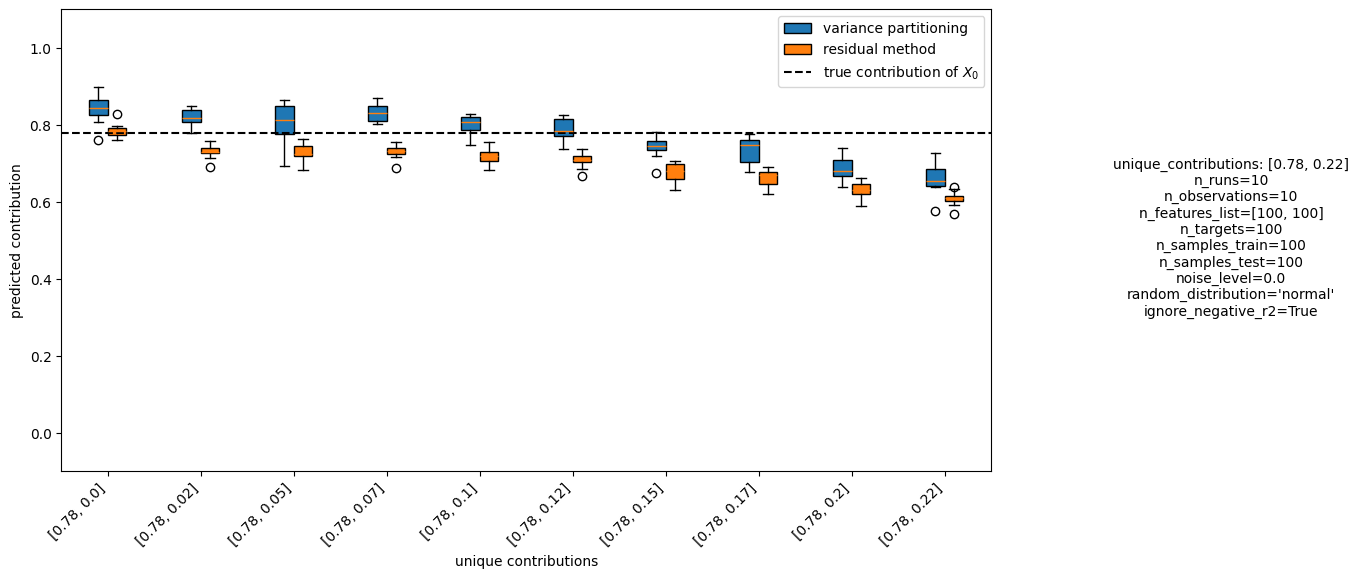

[........................................] 100% | 24.73 sec | Varying unique contributions | 


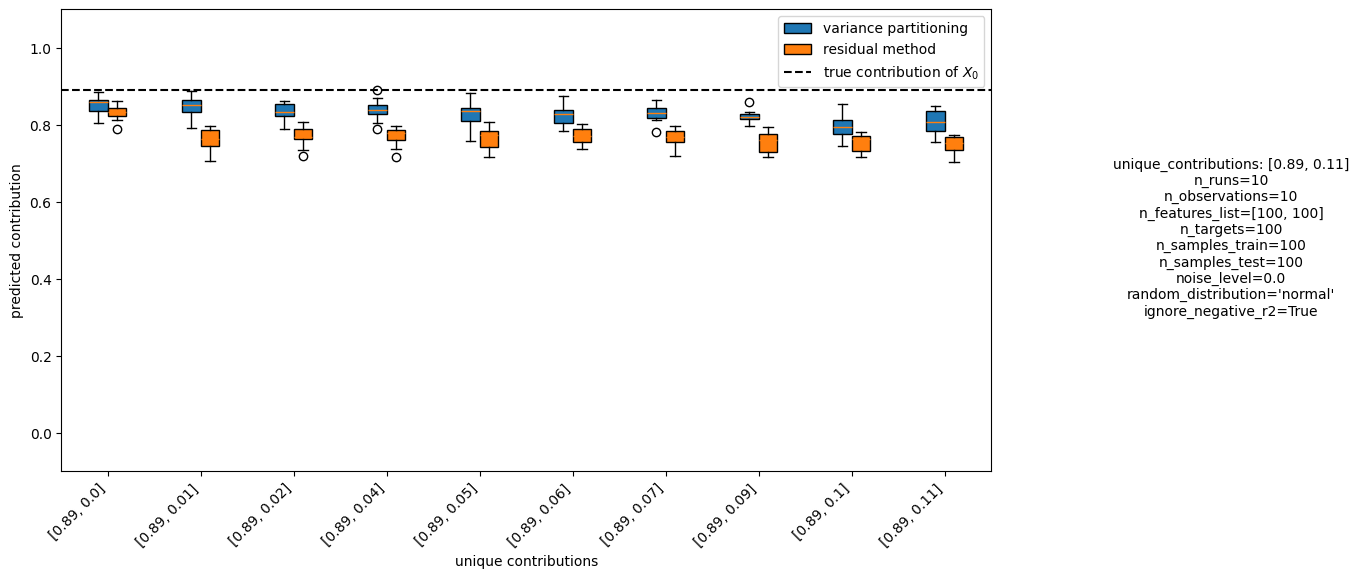

[........................................] 100% | 24.81 sec | Varying unique contributions | 


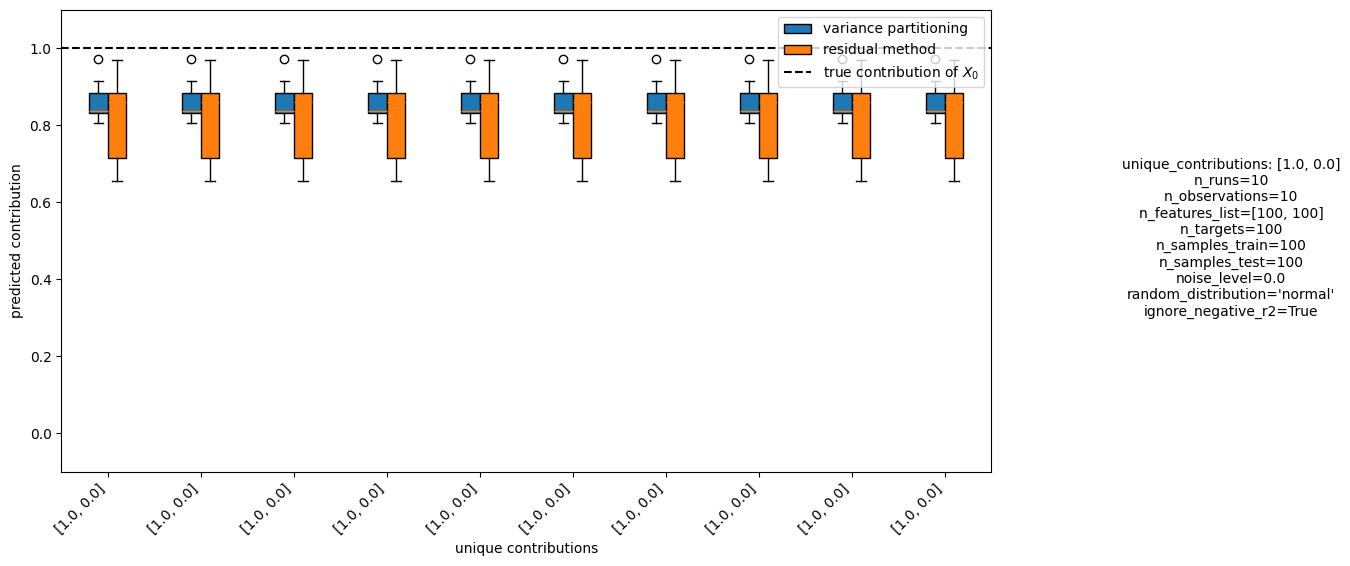

In [19]:
for x0_unique_contribution in x0_unique_contributions:
    contributions = [[x0_unique_contribution, round((1 - x0_unique_contribution) * x1 / (n_contributions - 1), 2)] for x1 in range(n_contributions)]
    run_experiment(contributions, "unique contributions", n_runs, n_observations, unique_contributions,
                   n_features_list, n_targets, n_samples_train, n_samples_test, noise_level, random_distribution,
                   ignore_negative_r2, use_refinement, use_ols)